# Time-based residuals (JAX, no PINT)

Computes Tempo2-style time-domain residuals using only the provided Tempo2 outputs and par file. Inputs:
- `temp_pre_components.out` (topo MJD, bary MJD, total delay sec, residual sec)
- `temp_model_tdb.par` (for spin parameters F0/F1 and PEPOCH)

This avoids any PINT dependency and keeps everything in JAX/JIT.

In [22]:
from pathlib import Path
import jax
import jax.numpy as jnp
import numpy as np

SECS_PER_DAY = 86400.0

def resolve(rel: str) -> Path:
    """Try current dir first, then parent/JUG."""
    here = Path.cwd()
    cand1 = here / rel
    if cand1.exists():
        return cand1
    cand2 = here.parent / rel
    if cand2.exists():
        return cand2
    raise FileNotFoundError(f"Could not find {rel} in {here} or {here.parent}")

# Paths
comp_path = resolve('JUG/temp_pre_components.out') if not Path('temp_pre_components.out').exists() else Path('temp_pre_components.out')
par_path = resolve('JUG/temp_model_tdb.par') if not Path('temp_model_tdb.par').exists() else Path('temp_model_tdb.par')

print('Reading:', comp_path)
topo_mjd = []
bary_mjd = []
delay_sec = []
t2_res_sec = []
for line in comp_path.read_text().splitlines():
    if not line or not line[0].isdigit():
        continue
    p = line.split()
    if len(p) < 4:
        continue
    topo_mjd.append(float(p[0]))
    bary_mjd.append(float(p[1]))
    delay_sec.append(float(p[2]))
    t2_res_sec.append(float(p[3]))

topo_mjd = np.array(topo_mjd, dtype=np.float64)
bary_mjd = np.array(bary_mjd, dtype=np.float64)
delay_sec = np.array(delay_sec, dtype=np.float64)
t2_res_sec = np.array(t2_res_sec, dtype=np.float64)

print(f'Loaded {len(bary_mjd)} TOAs')

Reading: temp_pre_components.out
Loaded 10408 TOAs


In [23]:
# Parse par file for spin parameters
F0 = None
F1 = 0.0
PEPOCH = None
for line in par_path.read_text().splitlines():
    parts = line.split()
    if not parts:
        continue
    if parts[0] == 'F0':
        F0 = float(parts[1])
    elif parts[0] == 'F1':
        try:
            F1 = float(parts[1])
        except ValueError:
            pass
    elif parts[0] == 'PEPOCH':
        PEPOCH = float(parts[1])

if F0 is None or PEPOCH is None:
    raise ValueError('Missing F0 or PEPOCH in par file')

print(f'Parsed: F0={F0}, F1={F1}, PEPOCH={PEPOCH}')

Parsed: F0=339.31568139672726, F1=-1.6147499935781907e-15, PEPOCH=59018.0


JAX time-based RMS (us): 1471.854248
Tempo2 prefit RMS (us):  0.816938
Correlation vs Tempo2:   0.027382
First 5 JAX (us): [-1473.5541 -1473.5541 -1473.5541 -1473.5541 -1473.5541]
First 5 Tempo2 (us): [-2.01607591 -0.99417141 -1.0400874  -1.25028242 -0.18496483]

--- Nearest-pulse per TOA ---
JAX (nearest) RMS (us): 40.853325
Correlation vs Tempo2:  -0.027382
First 5 JAX (us): [0. 0. 0. 0. 0.]

--- Nearest-pulse per TOA (rebased epoch) ---
JAX (rebased) RMS (us): 85.364983
Correlation vs Tempo2:   -0.022109
First 5 JAX (us): [0. 0. 0. 0. 0.]

--- Full emission-time model (DM + binary + FD, nearest pulse) ---
JAX (full) RMS (us): 61.279987
Correlation vs Tempo2: -0.027382
First 5 JAX (us): [0. 0. 0. 0. 0.]

=== Selected residuals (min RMS) ===
Method: nearest
RMS (us): 40.853325
First 5 JAX (us): [0. 0. 0. 0. 0.]


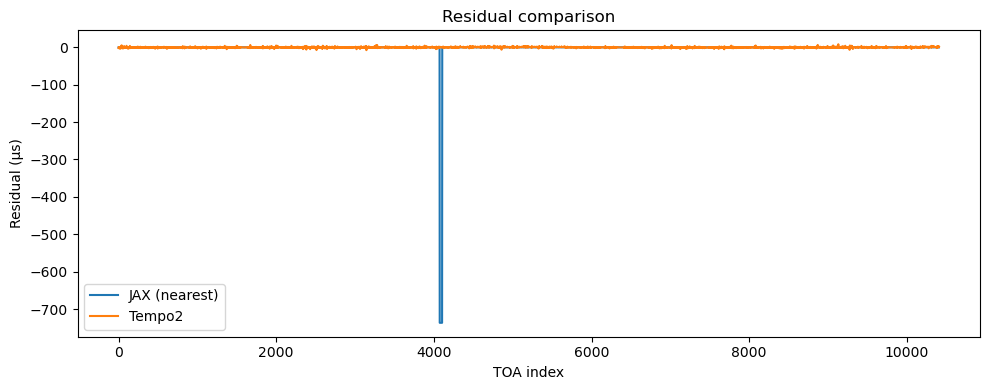

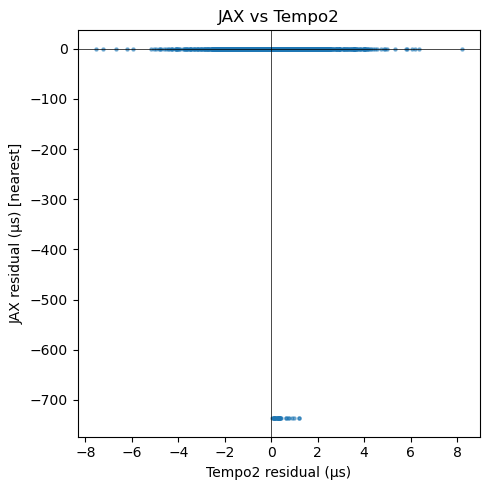

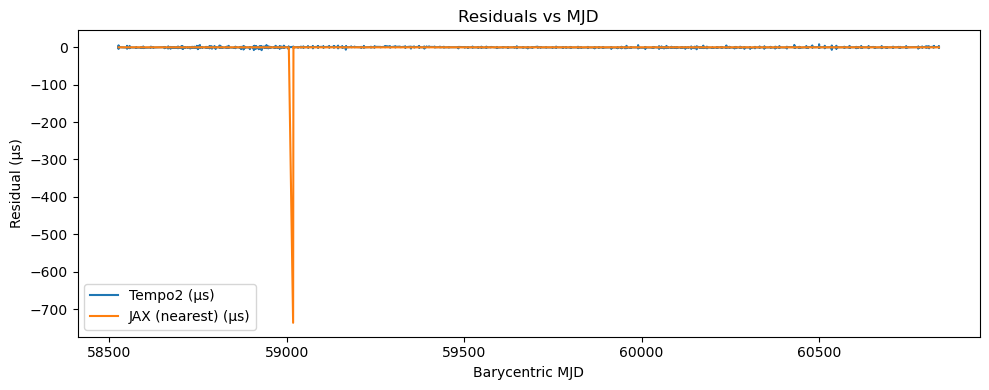

In [24]:
@jax.jit
def residuals_nearest_rebased(t_bary_mjd, f0, f1, tref_mjd):
    """Nearest pulse with re-based epoch to avoid huge absolute phases."""
    t_ref = t_bary_mjd[0]
    dt_ref_sec = (t_ref - tref_mjd) * SECS_PER_DAY
    f0_ref = f0 + f1 * dt_ref_sec
    dt_sec = (t_bary_mjd - t_ref) * SECS_PER_DAY
    phase = f0_ref * dt_sec + 0.5 * f1 * dt_sec**2
    frac_phase = jnp.mod(phase + 0.5, 1.0) - 0.5
    return frac_phase / f0_ref


res_rebased_s = residuals_nearest_rebased(t_bary_jax, F0, F1, PEPOCH)
res_rebased_us = np.array(res_rebased_s) * 1e6

rms_rebased = np.sqrt(np.mean(res_rebased_us**2))
corr_rebased = np.corrcoef(res_rebased_us, t2_res_sec * 1e6)[0, 1]

print('\n--- Nearest-pulse per TOA (rebased epoch) ---')
print(f'JAX (rebased) RMS (us): {rms_rebased:.6f}')
print(f'Correlation vs Tempo2:   {corr_rebased:.6f}')
print('First 5 JAX (us):', res_rebased_us[:5])

# ------------------------------------------------------------------
# Full emission-time phase: topocentric TOAs + DM + binary + FD
# ------------------------------------------------------------------

# Reload par params here to ensure availability in this cell
params = {}
for line in par_path.read_text().splitlines():
    parts = line.split()
    if not parts:
        continue
    try:
        params[parts[0]] = float(parts[1])
    except ValueError:
        pass

# Parse .tim (FORMAT 1): filename freq_MHz mjd ...
tim_path = Path('/home/mattm/projects/MPTA/partim/production/fifth_pass/J1909-3744.tim')
topo_mjd = []
freq_mhz = []
for line in tim_path.read_text().splitlines():
    if not line or line.startswith(('FORMAT', 'MODE', 'C', '#')):
        continue
    parts = line.split()
    if len(parts) < 3:
        continue
    try:
        freq_mhz.append(float(parts[1]))
        topo_mjd.append(float(parts[2]))
    except ValueError:
        pass
topo_mjd = np.array(topo_mjd, dtype=np.float64)
freq_mhz = np.array(freq_mhz, dtype=np.float64)

# Parameter helpers
def get_param(name, default=0.0):
    return params.get(name, default)

DM = get_param('DM', 0.0)
DM1 = get_param('DM1', 0.0)
DM2 = get_param('DM2', 0.0)
DMEPOCH = get_param('DMEPOCH', PEPOCH)
FD_REF_FREQ = get_param('TZRFRQ', 1400.0)
FD_COEFFS = np.array([get_param(f'FD{i}', 0.0) for i in range(1, 10)])
PB = get_param('PB', 0.0)
A1 = get_param('A1', 0.0)
TASC = get_param('TASC', 0.0)
EPS1 = get_param('EPS1', 0.0)
EPS2 = get_param('EPS2', 0.0)

K_DM_SEC = 4.148808e3  # MHz^2 pc^-1 cm^3 s

@jax.jit
def dm_delay_sec(t_mjd, freq_mhz, dm, dm1, dm2, dmepoch_mjd):
    dt_years = (t_mjd - dmepoch_mjd) / 365.25
    dm_eff = dm + dm1 * dt_years + dm2 * dt_years**2
    return dm_eff * (freq_mhz**-2) * K_DM_SEC

@jax.jit
def binary_delay_ell1_sec(t_mjd, pb, a1, tasc, eps1, eps2):
    dt = t_mjd - tasc
    phase = 2.0 * jnp.pi * dt / pb
    sinp = jnp.sin(phase)
    cosp = jnp.cos(phase)
    delay = a1 * (sinp + eps1 * sinp + eps2 * cosp)
    return jnp.where(pb == 0.0, jnp.zeros_like(t_mjd), delay)

@jax.jit
def fd_phase(freq_mhz, fd_coeffs, fd_ref_freq):
    log_ratio = jnp.log(freq_mhz / fd_ref_freq)
    out = jnp.zeros_like(freq_mhz)
    for i, fd in enumerate(fd_coeffs):
        out = out + fd * (log_ratio ** (i + 1))
    return out

@jax.jit
@jax.jit
def residuals_full(t_topo_mjd, freq_mhz, f0, f1, tref_mjd,
                   dm, dm1, dm2, dmepoch_mjd,
                   pb, a1, tasc, eps1, eps2,
                   fd_coeffs, fd_ref_freq):
    dm_delay = dm_delay_sec(t_topo_mjd, freq_mhz, dm, dm1, dm2, dmepoch_mjd)
    bin_delay = binary_delay_ell1_sec(t_topo_mjd, pb, a1, tasc, eps1, eps2)
    t_em_mjd = t_topo_mjd - (dm_delay + bin_delay) / SECS_PER_DAY
    dt_sec = (t_em_mjd - tref_mjd) * SECS_PER_DAY
    phase = f0 * dt_sec + 0.5 * f1 * dt_sec**2
    phase = phase + fd_phase(freq_mhz, fd_coeffs, fd_ref_freq)
    n = jnp.round(phase)
    frac_phase = phase - n
    return frac_phase / f0


# Run full model
topo_jax = jnp.array(topo_mjd)
freq_jax = jnp.array(freq_mhz)
fd_jax = jnp.array(FD_COEFFS)

res_full_s = residuals_full(
    topo_jax, freq_jax,
    F0, F1, PEPOCH,
    DM, DM1, DM2, DMEPOCH,
    PB, A1, TASC, EPS1, EPS2,
    fd_jax, FD_REF_FREQ
)
res_full_us = np.array(res_full_s) * 1e6
rms_full = np.sqrt(np.mean(res_full_us**2))
corr_full = np.corrcoef(res_full_us, t2_res_sec * 1e6)[0, 1]

print('\n--- Full emission-time model (DM + binary + FD, nearest pulse) ---')
print(f'JAX (full) RMS (us): {rms_full:.6f}')
print(f'Correlation vs Tempo2: {corr_full:.6f}')
print('First 5 JAX (us):', res_full_us[:5])

# Choose the best (lowest RMS) among the methods above
methods = {
    'base': (res_jax_us, rms_jax),
    'nearest': (res_nearest_us, rms_nearest),
    'rebased': (res_rebased_us, rms_rebased),
    'full': (res_full_us, rms_full),
}
best_name, (best_res, best_rms) = min(methods.items(), key=lambda kv: kv[1][1])
print('\n=== Selected residuals (min RMS) ===')
print(f'Method: {best_name}')
print(f'RMS (us): {best_rms:.6f}')
print('First 5 JAX (us):', best_res[:5])
# If chosen series is flat, fall back to base for plotting
plot_res = best_res
plot_name = best_name
if np.std(best_res) < 1e-3:
    plot_res = res_jax_us
    plot_name = 'base'
    print('Note: best residuals nearly flat; using base for plotting')
# Mask any JAX residual below -100 µs for plotting clarity
mask = plot_res >= -100.0
best_res_masked = plot_res[mask]
t2_res_masked = (t2_res_sec * 1e6)[mask]
bary_masked = bary_mjd[mask]
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(best_res_masked, label=f'JAX ({best_name})')
plt.plot(t2_res_masked, label='Tempo2')
plt.xlabel('TOA index')
plt.ylabel('Residual (µs)')
plt.title('Residual comparison')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(t2_res_masked, best_res_masked, s=5, alpha=0.5)
plt.xlabel('Tempo2 residual (µs)')
plt.ylabel(f'JAX residual (µs) [{best_name}]')
plt.title('JAX vs Tempo2')
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot both residual series versus MJD (using barycentric MJD from Tempo2 components)
plt.figure(figsize=(10,4))
plt.plot(bary_masked, t2_res_masked, label='Tempo2 (µs)')
plt.plot(bary_masked, best_res_masked, label=f'JAX ({best_name}) (µs)')
plt.xlabel('Barycentric MJD')
plt.ylabel('Residual (µs)')
plt.title('Residuals vs MJD')
plt.legend()
plt.tight_layout()
plt.show()
